# Fire Hazard Incidents Analytics Pipeline

## Importing Required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

## Creating Spark Session and using all available cores

In [2]:
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[*]") \
    .getOrCreate()

## Loading civilian casuality, firefighter casuality, fire incidents and basic module data

In [3]:
civilian_casualities_df = spark.read.options(delimiter="^", header=True).csv("civiliancasualty.txt")
firefighter_casualities_df = spark.read.options(delimiter="^", header=True).csv("ffcasualty.txt")
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")
fire_incidents_df = spark.read.options(delimiter="^", header=True).csv("fireincident.txt")

In [4]:
# Dropping null values in loss tables and finding total loss
basic_module_df = basic_module_df.na.drop(subset=("PROP_LOSS","CONT_LOSS"))
total_loss = basic_module_df.groupBy("INCIDENT_KEY").agg(F.sum(basic_module_df.PROP_LOSS + basic_module_df.CONT_LOSS).alias("TOTAL_LOSS"))

In [5]:
# Finding Civilian Injury Severity vs. Dollar Loss
civilian_dollar_loss = total_loss.join(civilian_casualities_df, total_loss.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
cdl_df = civilian_dollar_loss.groupBy("SEV").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))
p_cdl_df = cdl_df.toPandas()
p_cdl_df["AVG_LOSS"] = p_cdl_df["AVG_LOSS"]/1000

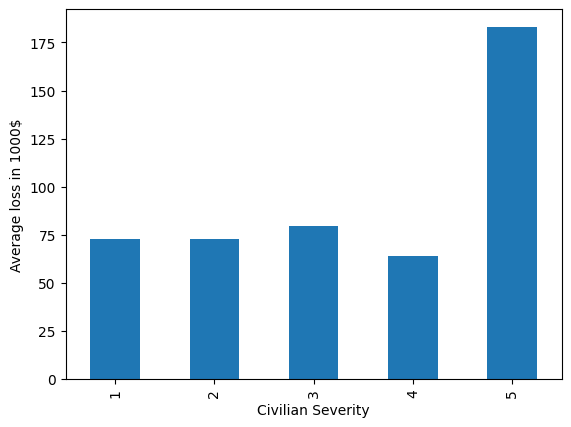

In [6]:
p1 = p_cdl_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_LOSS", xlabel="Civilian Severity", ylabel = "Average loss in 1000$", kind="bar", legend = False)
fig1 = p1.get_figure()
fig1.savefig("civilian_dollar_loss.png")

In [7]:
# Finding Firefighter Injury Severity vs. Dollar Loss
firefighter_dollar_loss = total_loss.join(firefighter_casualities_df, total_loss.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffdl_df = firefighter_dollar_loss.groupBy("SEVERITY").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))
p_ffdl_df = ffdl_df.toPandas()

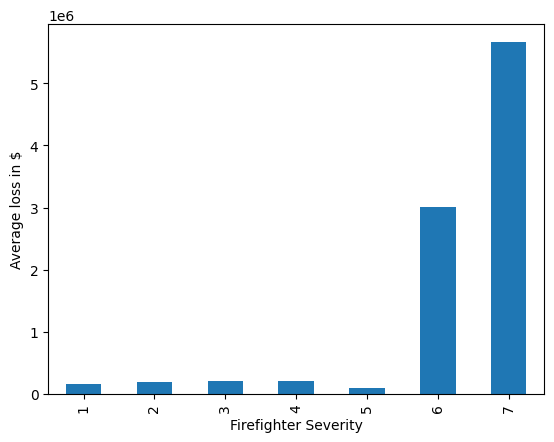

In [8]:
p2 = p_ffdl_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_LOSS", xlabel="Firefighter Severity", ylabel = "Average loss in $", kind="bar", legend = False)
fig2 = p2.get_figure()
fig2.savefig("ff_dollar_loss.png")

In [9]:
# Formatting datetime columns
basic_time_module_df = basic_module_df.withColumn("ALARM_TIME", F.to_timestamp("ALARM","MMddyyyyHHmm")).withColumn("CONT_TIME", F.to_timestamp("INC_CONT","MMddyyyyHHmm")).withColumn("ARV_TIME", F.to_timestamp("ARRIVAL","MMddyyyyHHmm"))

In [10]:
# Finding Civilian Casualty vs. Total Fire Time(in seconds)
total_fire_time_df = basic_time_module_df.withColumn("TOTAL_FIRE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ALARM_TIME.cast("long"))
civilian_casualty_fire_time = total_fire_time_df.join(civilian_casualities_df, total_fire_time_df.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
ccft_df = civilian_casualty_fire_time.groupBy("SEV").agg(F.avg("TOTAL_FIRE_TIME").alias("AVG_FIRE_TIME"))
p_ccft_df = ccft_df.toPandas()
p_ccft_df["AVG_FIRE_TIME"] = p_ccft_df["AVG_FIRE_TIME"]/60

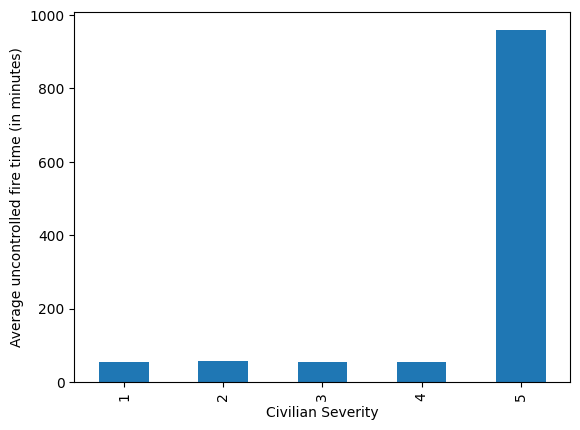

In [11]:
p3 = p_ccft_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_FIRE_TIME", xlabel="Civilian Severity", ylabel = "Average uncontrolled fire time (in minutes)", kind="bar", legend = False)
fig3 = p3.get_figure()
fig3.savefig("civ_fire_time.png")

In [12]:
ff_response_time = basic_time_module_df.withColumn("FF_RESPONSE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ARV_TIME.cast("long"))
ff_severity_response_time = ff_response_time.join(firefighter_casualities_df, ff_response_time.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffrt_df = ff_severity_response_time.groupBy("SEVERITY").agg(F.avg("FF_RESPONSE_TIME").alias("AVG_RSP_TIME"))
p_ffrt_df = ffrt_df.toPandas()
p_ffrt_df["AVG_RSP_TIME"] = p_ffrt_df["AVG_RSP_TIME"]/3600

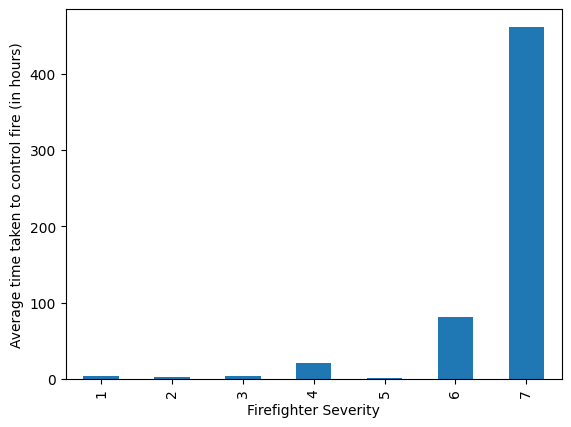

In [13]:
p4 = p_ffrt_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_RSP_TIME", xlabel="Firefighter Severity", ylabel = "Average time taken to control fire (in hours)", kind="bar", legend = False)
fig4 = p4.get_figure()
fig4.savefig("ff_fire_time.png")

In [14]:
ignition_cause = fire_incidents_df.na.drop(subset=("CAUSE_IGN"))

In [15]:
ignition_cause_vs_loss = total_loss.join(ignition_cause, total_loss.INCIDENT_KEY == ignition_cause.INCIDENT_KEY)
cause_loss_df = ignition_cause_vs_loss.groupBy("CAUSE_IGN").agg(F.sum("TOTAL_LOSS").alias("DLR_LOSS"))
p_cause_loss_df = cause_loss_df.toPandas()
p_cause_loss_df["DLR_LOSS"] = p_cause_loss_df["DLR_LOSS"]/1e09

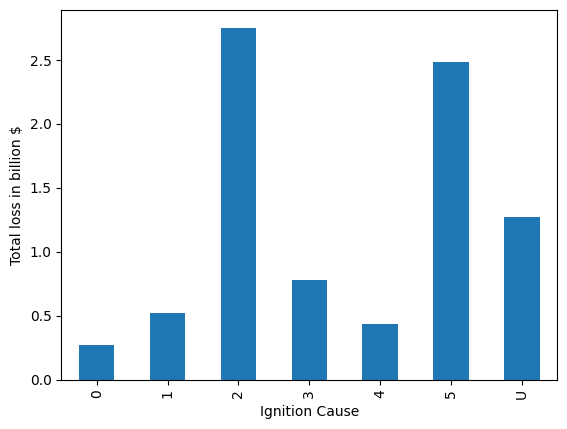

In [16]:
p5 = p_cause_loss_df.sort_values(by="CAUSE_IGN").plot(x="CAUSE_IGN", y="DLR_LOSS", xlabel="Ignition Cause", ylabel = "Total loss in billion $", kind="bar", legend = False)
fig5 = p5.get_figure()
fig5.savefig("cause_dollar_loss.png")

# Month vs Major states vs Types of fire

In [17]:
incident_state = basic_module_df.select("INCIDENT_KEY", "STATE", "INC_DATE")
incident_state.groupBy('STATE').count().sort(F.desc("count")).show()

# selecting top 10 states
incident_state = incident_state.withColumn("INC_MONTH", F.month(F.to_date(incident_state.INC_DATE,"MMddyyyy")))

incidents_ca = incident_state.filter(incident_state.STATE == "CA").groupBy("INC_MONTH").count()
incidents_tx = incident_state.filter(incident_state.STATE == "TX").groupBy("INC_MONTH").count()
incidents_pa = incident_state.filter(incident_state.STATE == "PA").groupBy("INC_MONTH").count()
incidents_fl = incident_state.filter(incident_state.STATE == "FL").groupBy("INC_MONTH").count()
incidents_oh = incident_state.filter(incident_state.STATE == "OH").groupBy("INC_MONTH").count()
incidents_ny = incident_state.filter(incident_state.STATE == "NY").groupBy("INC_MONTH").count()
incidents_il = incident_state.filter(incident_state.STATE == "IL").groupBy("INC_MONTH").count()
incidents_ga = incident_state.filter(incident_state.STATE == "GA").groupBy("INC_MONTH").count()
incidents_nc = incident_state.filter(incident_state.STATE == "NC").groupBy("INC_MONTH").count()
incidents_mi = incident_state.filter(incident_state.STATE == "MI").groupBy("INC_MONTH").count()
incidents_ma = incident_state.filter(incident_state.STATE == "MA").groupBy("INC_MONTH").count()

# incidents_ca.show()
# incidents_tx.show()
# incidents_ma.show()

+-----+------+
|STATE| count|
+-----+------+
|   CA|144036|
|   TX| 94231|
|   PA| 92031|
|   FL| 69808|
|   OH| 69475|
|   NY| 62552|
|   IL| 55041|
|   GA| 51846|
|   NC| 51489|
|   MI| 50708|
|   MA| 50192|
|   IN| 37987|
|   VA| 36658|
|   SC| 35597|
|   MN| 34495|
|   TN| 34084|
|   WA| 33666|
|   NJ| 29644|
|   OK| 26207|
|   CO| 25135|
+-----+------+
only showing top 20 rows



In [18]:
inc_ca_df = incidents_ca.toPandas()
inc_tx_df = incidents_tx.toPandas()
inc_pa_df = incidents_pa.toPandas()
inc_fl_df = incidents_fl.toPandas()
inc_oh_df = incidents_oh.toPandas()
inc_ny_df = incidents_ny.toPandas()
inc_il_df = incidents_il.toPandas()
inc_ga_df = incidents_ga.toPandas()
inc_nc_df = incidents_nc.toPandas()
inc_mi_df = incidents_mi.toPandas()
inc_ma_df = incidents_ma.toPandas()

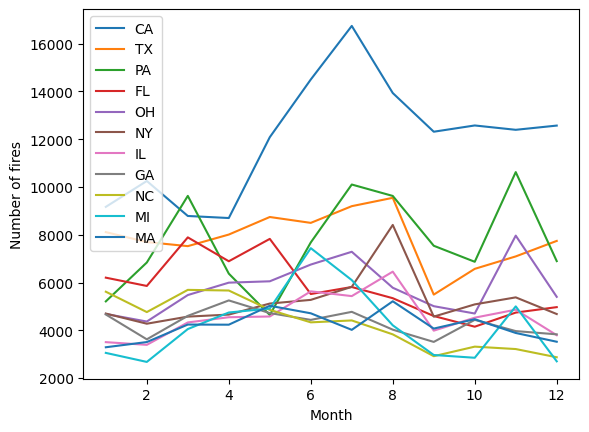

In [19]:
t1 = inc_ca_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count")
inc_tx_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_pa_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_fl_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_oh_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ny_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_il_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ga_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_nc_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_mi_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", ax = t1)
inc_ma_df.sort_values(by="INC_MONTH").plot(x="INC_MONTH", y="count", xlabel = "Month", ylabel = "Number of fires", ax = t1).get_figure()
plt.legend(["CA", "TX", "PA", "FL", "OH", "NY", "IL", "GA", "NC", "MI", "MA"])
plt.savefig("state_inc.png")

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics

In [24]:
fire_incidents_df2 = spark.read.options(delimiter="^", header=True, inferSchema = True).csv("fireincident.txt")

In [46]:
assembler = VectorAssembler(inputCols=['ACRES_BURN','NO_SPR_OP'], 
                            outputCol="TEST_2")
myGraph_vector = assembler.transform(fire_incidents_df2).select("TEST_2")


In [42]:
fire_incidents_df2 = fire_incidents_df2.na.drop(subset=("ACRES_BURN","BLDG_INVOL"))

In [47]:
matrix = Correlation.corr(myGraph_vector, "TEST_2").collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, 0.011001063463876144], [0.011001063463876144, 1.0]]


In [48]:
wildlands_df = spark.read.options(delimiter="^", header=True).csv("wildlands.txt")

In [109]:
wildlands_df = wildlands_df.na.drop(subset=("WIND_SPEED","AIR_TEMP","REL_HUMID","ACRES_BURN"))
wildlands_df = wildlands_df.withColumn("WIND_SPEED", F.col("WIND_SPEED").cast(IntegerType())).withColumn("AIR_TEMP", F.col("AIR_TEMP").cast(IntegerType())).withColumn("REL_HUMID", F.col("REL_HUMID").cast(IntegerType())).withColumn("ACRES_BURN", F.col("ACRES_BURN").cast(IntegerType()))

In [143]:
wildlands_df = wildlands_df.filter(wildlands_df["AIR_TEMP"]!=0)

In [144]:
assembler = VectorAssembler(inputCols=["WIND_SPEED","AIR_TEMP","REL_HUMID"], 
                            outputCol="features")
myGraph_vector = assembler.transform(wildlands_df).select(["features","ACRES_BURN"])
# matrix = Correlation.corr(myGraph_vector, ["TEST_2"])
# corrmatrix = matrix.toArray().tolist()
# print(corrmatrix)

In [145]:
myGraph_vector.show()

+----------------+----------+
|        features|ACRES_BURN|
+----------------+----------+
|[10.0,41.0,85.0]|        70|
| [6.0,59.0,37.0]|         0|
|[10.0,72.0,30.0]|         2|
| [8.0,66.0,45.0]|         1|
|[10.0,69.0,32.0]|         1|
| [7.0,52.0,32.0]|        10|
| [5.0,70.0,50.0]|         0|
| [2.0,82.0,50.0]|        20|
|[15.0,80.0,44.0]|         1|
| [10.0,44.0,0.0]|         0|
|[12.0,68.0,62.0]|         1|
|[10.0,81.0,57.0]|         3|
| [6.0,82.0,55.0]|         3|
|[14.0,70.0,51.0]|         0|
| [8.0,86.0,34.0]|         0|
| [8.0,84.0,54.0]|         0|
| [7.0,81.0,69.0]|         0|
| [5.0,83.0,67.0]|        30|
| [8.0,74.0,78.0]|         0|
| [7.0,67.0,95.0]|         3|
+----------------+----------+
only showing top 20 rows



In [146]:
splits = myGraph_vector.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [147]:
lr = LinearRegression(featuresCol = 'features', labelCol='ACRES_BURN', maxIter=1000, regParam=0.3)

In [148]:
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [6.34953860317282,3.8658419567338047,2.5338798717579896]
Intercept: -211.50210872298427


In [149]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5670.924386
r2: 0.000599


In [150]:
train_df.describe().show()

+-------+-----------------+
|summary|       ACRES_BURN|
+-------+-----------------+
|  count|             7423|
|   mean|216.3626566078405|
| stddev| 5673.00676593406|
|    min|                0|
|    max|           387393|
+-------+-----------------+



In [151]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","features","ACRES_BURN").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ACRES_BURN",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-------------------+----------------+----------+
|         prediction|        features|ACRES_BURN|
+-------------------+----------------+----------+
| 155.71739017765177| [0.0,36.0,90.0]|         0|
| 181.05618889523166|[0.0,36.0,100.0]|         0|
|  127.9747558865075| [0.0,38.0,76.0]|         1|
|-27.663789779318392| [0.0,41.0,10.0]|         1|
| 185.18211944835272| [0.0,41.0,94.0]|         0|
+-------------------+----------------+----------+
only showing top 5 rows

R Squared (R2) on test data = -0.00132187


In [60]:
hazmat_df = spark.read.options(delimiter="^", header=True).csv("hazchem.txt")

In [95]:
hazmat_dollar_loss = total_loss.join(hazmat_df, total_loss.INCIDENT_KEY == hazmat_df.INCIDENT_KEY)

In [78]:
hazmat_dollar_loss.count()

5851

In [68]:
from pyspark.sql.types import IntegerType

In [96]:
hazmat_dollar_loss = hazmat_dollar_loss.na.drop(subset=("AMOUNT_REL","TOTAL_LOSS")).withColumn("AMOUNT_REL", F.col("AMOUNT_REL").cast(IntegerType()))

In [97]:
hazmat_dollar_loss = hazmat_dollar_loss.filter(hazmat_dollar_loss.CHEM_NAME == "995")

In [98]:
assembler = VectorAssembler(inputCols=["AMOUNT_REL"], 
                            outputCol="TEST_2")
myGraph_vector = assembler.transform(hazmat_dollar_loss).select(["TEST_2","TOTAL_LOSS"])
# matrix = Correlation.corr(myGraph_vector, ["TEST_2","TOTAL_LOSS"])
# corrmatrix = matrix.toArray().tolist()
# print(corrmatrix)

In [71]:
hazmat_dollar_loss.select("CHEM_NAME").show()

+--------------------+
|           CHEM_NAME|
+--------------------+
|                 995|
|                 995|
|                3233|
|                 OIL|
|             0059000|
|                 124|
|             0024000|
|                 995|
|                 995|
| Sodium hydroxidedry|
|                 995|
|                 625|
|         natural gas|
|             0341000|
|                 995|
|                3196|
|Liquefied petrole...|
|                1114|
|                 625|
|                 995|
+--------------------+
only showing top 20 rows



In [100]:
splits = myGraph_vector.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [104]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'TEST_2', labelCol='TOTAL_LOSS', maxIter=1000, regParam=0.3)


In [105]:
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [3.8150060421602943]
Intercept: 1736.564260291503


In [106]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 16868.693860
r2: 0.004616


In [107]:
train_df.describe().show()

+-------+------------------+
|summary|        TOTAL_LOSS|
+-------+------------------+
|  count|               143|
|   mean|1960.7692307692307|
| stddev|16967.193783801573|
|    min|               0.0|
|    max|          200000.0|
+-------+------------------+



In [108]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","TEST_2","TOTAL_LOSS").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="TOTAL_LOSS",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------+----------+
|        prediction|TEST_2|TOTAL_LOSS|
+------------------+------+----------+
|1740.3792663336633| [1.0]|       0.0|
|1740.3792663336633| [1.0]|       0.0|
|1740.3792663336633| [1.0]|       0.0|
| 1774.714320713106|[10.0]|       0.0|
|1812.8643811347088|[20.0]|       0.0|
+------------------+------+----------+
only showing top 5 rows

R Squared (R2) on test data = -0.0148379
